# Quickstart to dask-image


Welcome to the quickstart guide for dask-image.

1. [Setting up your environment]('#environment_setup')
1. [Importing dask-image]('#imports')
1. [Reading in image data]('#reading_image_data')
    1. [Reading a single image]('#reading_a_single_image')
    1. [Reading multiple iamges]('#reading_multiple_images')

1. [Applying your own custom function to images]('#applying_custom_function')
    1. [Embarrassingly parallel problems]('#embarrassingly_parallel')

1. [Joining partial images together]('#joining_images')

1. [A segmentation analysis pipeline]('#segmentation_pipeline')
    1. [Filtering]('#filtering)
    1. [Segmenting]('#segmenting')
    1. [Analyzing]('#analyzing')
1. [Next steps]('#next_steps')

<a id='environment_setup'></a>
## Setting up your environment

Before you begin, ensure your Python environment contains:
* dask
* dask-image
* python-graphviz
* matplotlib
* numpy

You can refer to the full list of dependencies used for the `dask-examples` repository, available in the [`binder/environment.yml` file here](https://github.com/dask/dask-examples/blob/master/binder/environment.yml
) (note that the `nomkl` package is not available for Windows users): https://github.com/dask/dask-examples/blob/master/binder/environment.yml


<a id='imports'></a>
## Importing dask-image

When you import dask-image, be sure to use an underscore instead of a dash between the two words.

In [1]:
from dask_image import imread, ndfilters, ndmeasure
import dask.array as da

We'll also use matplotlib to display image results in this notebook.

In [3]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

<a id='reading_image_data'></a>
## Reading in image data

We'll use some example image data from the scikit-image library in this tutorial. These images are very small, but will allow us to demonstrate the functionality of dask-image.

<a id='reading_a_single_image'></a>
### Reading a single image

Let's load a public domain image of the astronaut Eileen Collins with dask-image [imread()](http://image.dask.org/en/latest/dask_image.imread.html). This image was originally downloaded from the NASA Great Images database <https://flic.kr/p/r9qvLn>.

In [4]:
filename = os.path.join('img', 'astronaut', 'astronaut.png')
print(filename)

img\astronaut\astronaut.png


dask.array<from-value, shape=(1, 512, 512, 3), dtype=uint8, chunksize=(1, 512, 512, 3)>


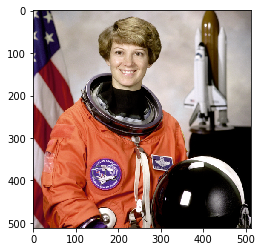

In [9]:
astronaut = imread.imread(filename)
print(astronaut)
plt.imshow(astronaut[0, ...])  # display the first (and only) frame of the image

This has created a dask array with `shape=(1, 512, 512, 3)`. This means it contains one image frame with 512 rows, 512 columns, and 3 color channels. 

Since the image is relatively small, it fits entirely within one dask-image chunk, with `chunksize=(1, 512, 512, 3)`.


<a id='reading_multiple_images'></a>
### Reading multiple images

In many cases, you may have multiple images stored on disk, for example:
`image_00.png`, `image_01.png`, ... `image_NN.png`. These can be read into a dask array as multiple image frames.

Here we have the astronaut image split into four non-overlapping tiles:
* `image_00.png` = top left image (index 0,0)
* `image_01.png` = top right image (index 0,1)
* `image_10.png` = bottom left image (index 1,0)
* `image_11.png` = bottom right image (index 1,1)

This filename pattern can be matched with regex: `image-*.png`

In [10]:
filename_pattern = 'img/astronaut/tiles/image-*.png'
tiled_astronaut_images = imread.imread(filename_pattern)
print(tiled_astronaut_images)

dask.array<concatenate, shape=(4, 256, 256, 3), dtype=uint8, chunksize=(1, 256, 256, 3)>


This has created a dask array with `shape=(4, 256, 256, 3)`. This means it contains four image frames; each with 256 rows, 256 columns, and 3 color channels. 

There are four chunks in this particular case. Each image frame here is a separate chunk with `chunksize=(1, 256, 256, 3)`.

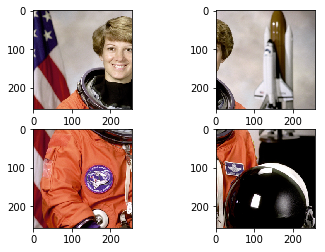

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ax[0,0].imshow(tiled_astronaut_images[0])
ax[0,1].imshow(tiled_astronaut_images[1])
ax[1,0].imshow(tiled_astronaut_images[2])
ax[1,1].imshow(tiled_astronaut_images[3])
plt.show()

<a id='applying_custom_function'></a>
## Applying your own custom function to images

Next you'll want to do some image processing, and apply a function to your images.

We'll use a very simple example: converting an RGB image to grayscale. But you can also use this method to apply arbittrary functions to dask iamges. To convert our image to grayscale, we'll use the equation to calcuate luminance ([reference pdf](http://www.poynton.com/PDFs/ColorFAQ.pdf))": 

`Y = 0.2125 R + 0.7154 G + 0.0721 B` 

We'll write the function for this equation as follows:

In [7]:
def grayscale(rgb):
    result = ((rgb[..., 0] * 0.2125) + 
              (rgb[..., 1] * 0.7154) + 
              (rgb[..., 2] * 0.0721))
    return result

Let's apply this function to the astronaut image we read in as a single file and visualize the computation graph. 

(Visualizing the computation graph isn't necessary most of the time but it's helpful to know what dask is doing under the hood, and it can also be very useful for debugging problems.)

dask.array<add, shape=(1, 512, 512), dtype=float64, chunksize=(1, 512, 512)>


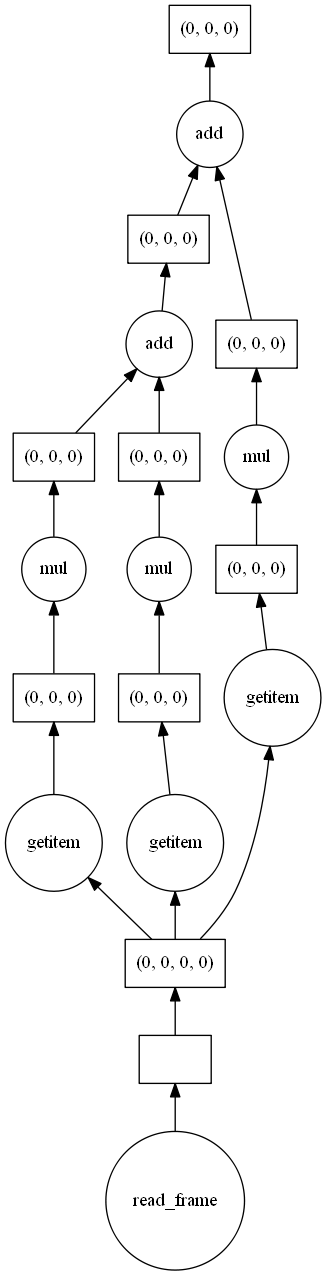

In [35]:
single_image_result = grayscale(astronaut)
print(single_image_result)
single_image_result.visualize()

We also see that there are no longer three color channels in the shape of the result, and that the output image is as expected.

Original image dimensions:  (1, 512, 512, 3)
Processed image dimensions: (4, 256, 256)


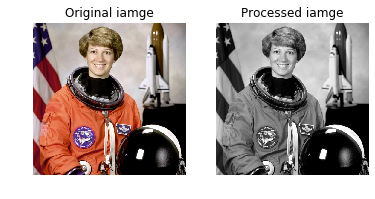

In [37]:
print("Original image dimensions: ", astronaut.shape)
print("Processed image dimensions:", result.shape)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(astronaut[0, ...])            # display the first (and only) frame of the image
ax1.imshow(single_image_result[0, ...], cmap='gray')  # display the first (and only) frame of the image

# Subplot headings
ax0.set_title('Original iamge')
ax1.set_title('Processed iamge')

# Don't display axes
ax0.axis('off')
ax1.axis('off')

# Display images
plt.show(fig)

<a id='embarrassingly_parallel'></a>
### Embarrassingly parallel problems

The xyntax is identical to apply a function to multiple images or dask chunks. This is an example of an embarrassingly parallel problem, and we see that dask automatically creates a computation graph for each chunk.


dask.array<add, shape=(4, 256, 256), dtype=float64, chunksize=(1, 256, 256)>


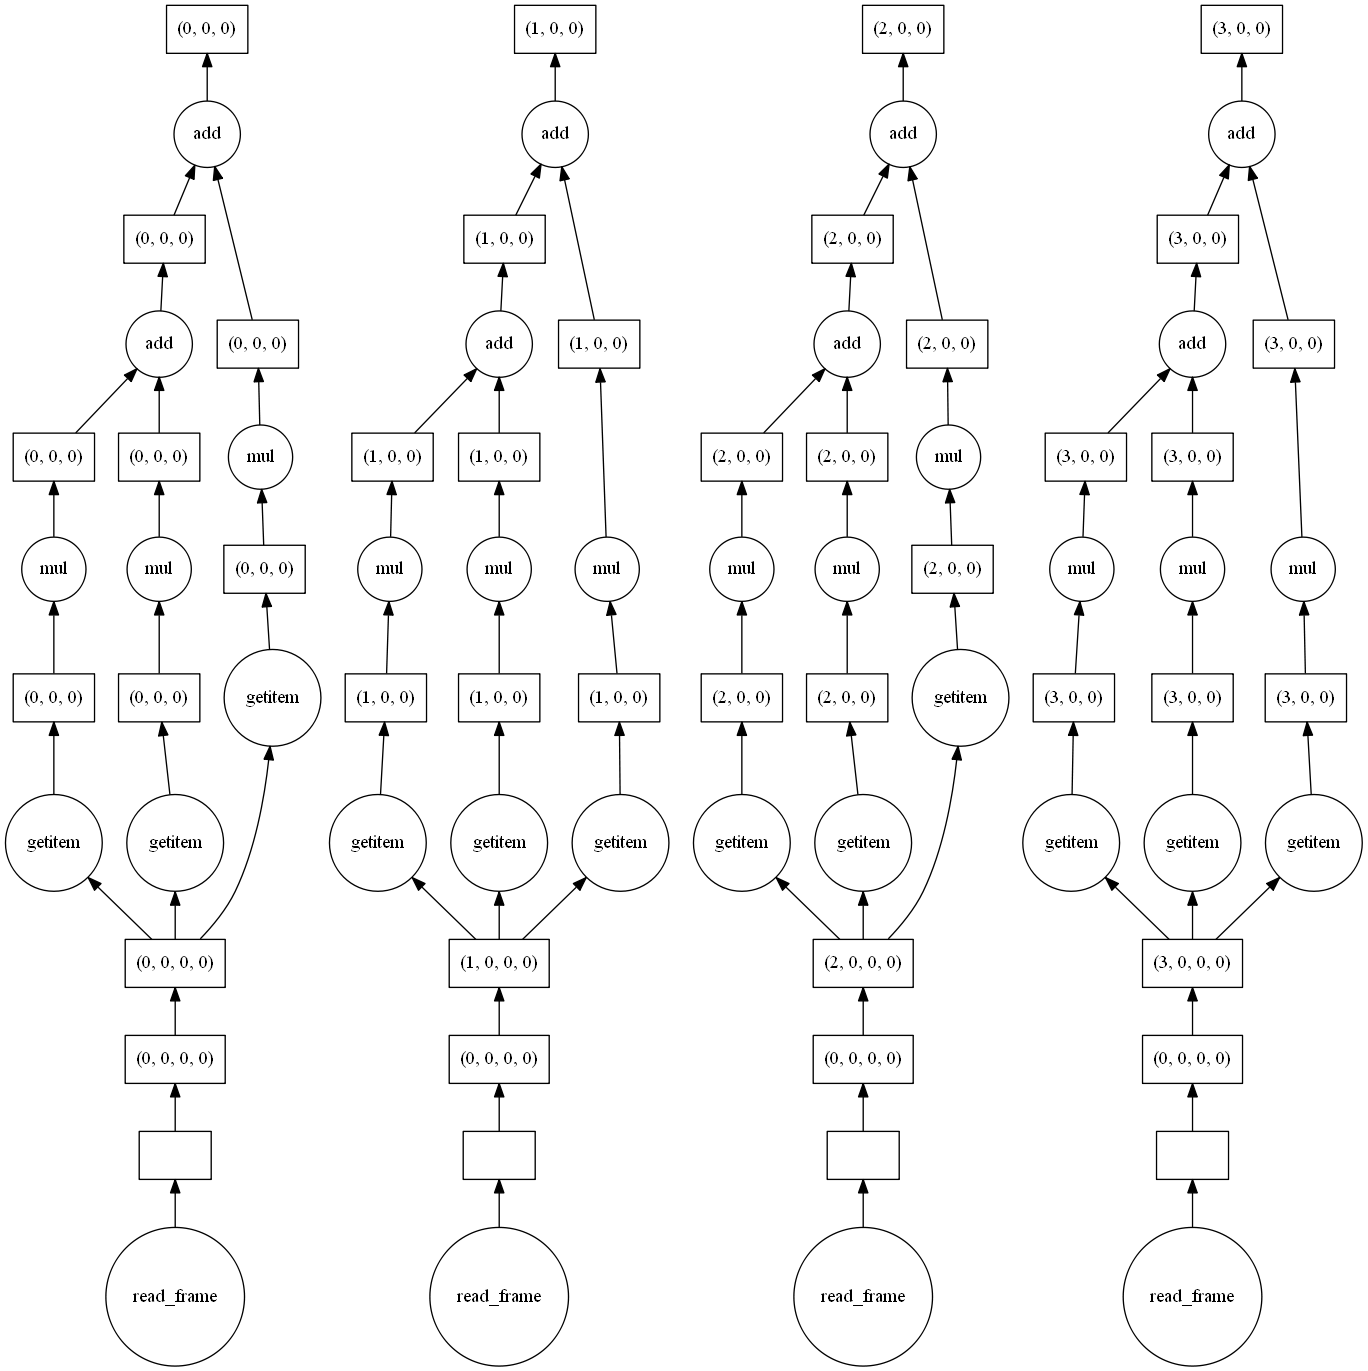

In [28]:
result = grayscale(tiled_astronaut_images)
print(result)
result.visualize()

Let's take a look at the results.

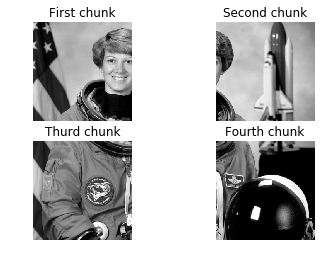

In [46]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
ax0.imshow(result[0, ...], cmap='gray')
ax1.imshow(result[1, ...], cmap='gray')
ax2.imshow(result[2, ...], cmap='gray')
ax3.imshow(result[3, ...], cmap='gray')

# Subplot headings
ax0.set_title('First chunk')
ax1.set_title('Second chunk')
ax2.set_title('Thurd chunk')
ax3.set_title('Fourth chunk')

# Don't display axes
ax0.axis('off')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

# Display images
plt.show(fig)

<a id='joining_images'></a>
## Joining partial images together

Ok, Things are looking pretty good! But how can we join these image chunks together?

So far, we haven't needed any information from neighboring pixels to do our calculations. But there are lots of functions (like those in [dask-image ndfilters](https://dask-image.readthedocs.io/en/latest/dask_image.ndfilters.html)) that *do* need this for accurate results. You could end up with unwanted edge effects if you don't tell dask how your images should be joined.

Dask has several ways to join chunks together: [Stack, Concatenate, and Block](http://docs.dask.org/en/latest/array-stack.html).

Block is very versatile, so we'll use that in this next example. You simply pass in a list (or list of lists) to tell dask the spatial relationship between image chunks.

(512, 512)


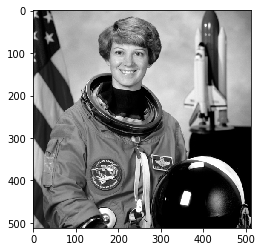

In [84]:
data = [[result[0, ...], result[1, ...]],
        [result[2, ...], result[3, ...]]]
full_image = da.block(data)
print(full_image.shape)
plt.imshow(full_image, cmap='gray')

<a id='segmentation_pipeline'></a>
## A segmentation analysis pipeline

We'll walk through a 

1. [Filtering]('#filtering)
1. [Segmenting]('#segmenting')
1. [Analyzing]('#analyzing')



<a id='filtering'></a>
### Filtering

Most analysis pipelines require some degree of image preprocessing. dask-image has a number of inbuilt filters available via [dask-image ndfilters](https://dask-image.readthedocs.io/en/latest/dask_image.ndfilters.html)

Commonly a guassian filter may used to smooth the image before segmentation. This causes some loss of sharpness in the image, but can improve segmentation quality for methods that rely on image thresholding.

In [85]:
smoothed_image = ndfilters.gaussian_filter(full_image, sigma=[1, 1])

We see a small amount of blur in the smoothed image.

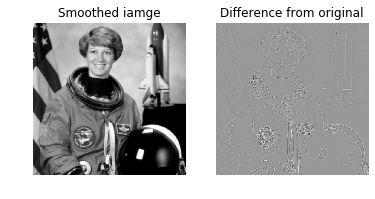

In [92]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
ax0.imshow(smoothed_image, cmap='gray')
ax1.imshow(smoothed_image - full_image, cmap='gray')

# Subplot headings
ax0.set_title('Smoothed iamge')
ax1.set_title('Difference from original')

# Don't display axes
ax0.axis('off')
ax1.axis('off')

# Display images
plt.show(fig)

Since the gaussian filter uses information from neighbouring pixels, the computational graph looks more complicated than the ones we looked at earlier. This is no longer embarrassingly parallel. Where possible dask keeps the computations for each of the four image chunks separate, but must combine information from different chunks near the edges.


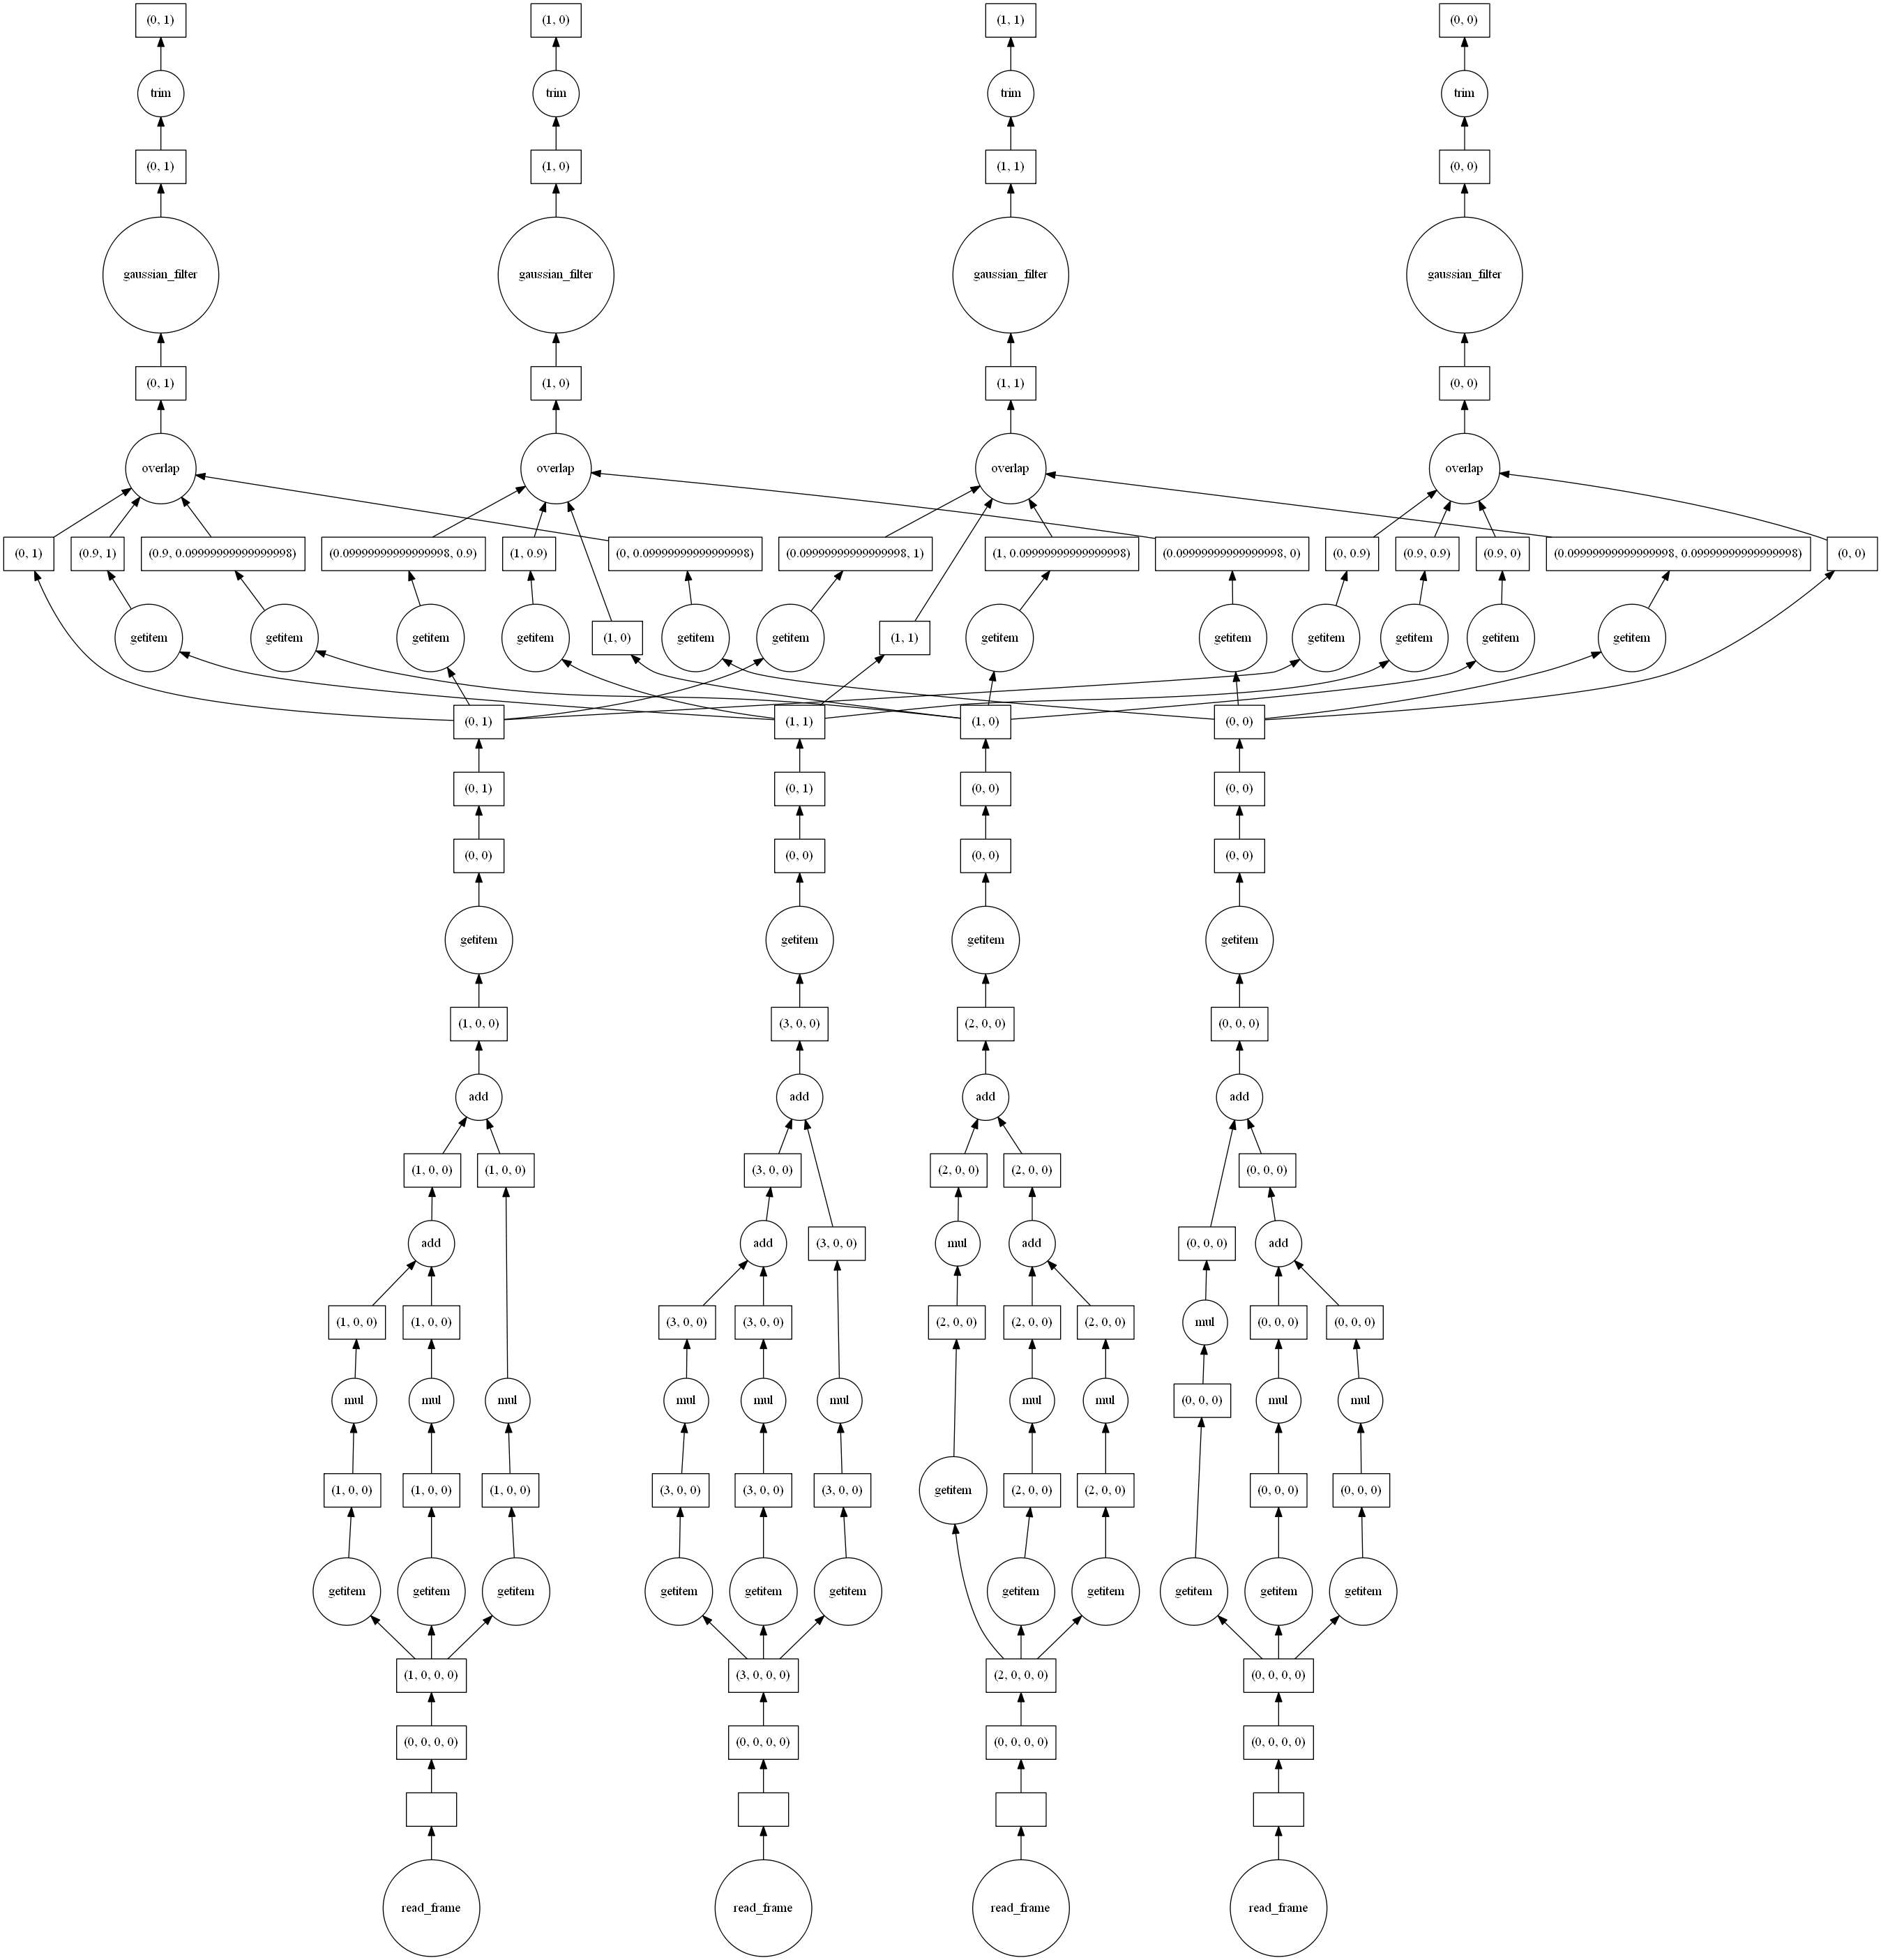

In [93]:
smoothed_image.visualize()

<a id='segmenting'></a>
### Segmenting

AFter the image preprocessing, we segment regions of interest from the data. We'll use a simple binary threshold as the cutoff.

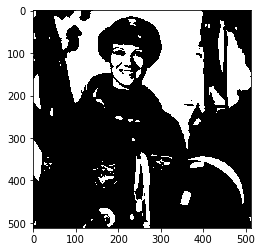

In [115]:
res = smoothed_image > 175
plt.imshow(res, cmap='gray')

Next, we label each region of connected pixels above the threshold value. For this we use the `;abel` function from [dask-image ndmeasure](https://dask-image.readthedocs.io/en/latest/dask_image.ndmeasure.html). This will return both the label image, and the number of labels.

In [116]:
label_image, num_labels = ndmeasure.label(res)

Number of labels: 91


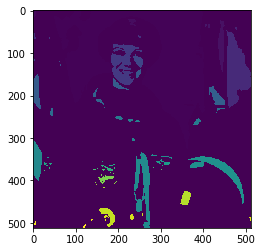

In [121]:
print("Number of labels:", int(num_labels))
plt.imshow(label_image, cmap='viridis')

<a id='analyzing'></a>
### Analyzing

There are a number of inbuilt functions in [dask-image ndmeasure](https://dask-image.readthedocs.io/en/latest/dask_image.ndmeasure.html) useful for quantitative analysis.

We'll use the `ndmeasure.mean()` and `ndmeasure.standard_deviation()` functions, and apply them to each label region with `ndmeasure.labeled_comprehension()`.

In [128]:
index = list(range(int(num_labels)))  # Note that we're including the background label=0 here, too.
out_dtype = float  # The data type we want to use for our results.
default = None     # The value to return if an element of index does not exist in the label image.
mean_values = ndmeasure.labeled_comprehension(full_image, label_image, index, ndmeasure.mean, out_dtype, default, pass_positions=False)
print(mean_values.compute())

[ 79.81593261 199.3415936  209.29658381 187.98744899 204.69359626
 218.157605   239.04592    196.19501667 190.2774625  176.09661176
 186.65226667 188.61858627 206.51222833 192.77738333 179.58653333
 199.70753602 195.4378525  210.740725   204.63689268 193.39392626
 175.86978333 176.13825714 175.6871     175.8433     176.64955
 193.59539096 200.29683605 200.5425059  204.7842521  198.86193763
 199.328775   204.0193     180.11391279 190.44675    200.05786765
 175.85482667 188.788625   208.22582342 192.97527083 198.98838281
 195.735425   181.87982    209.883504   195.90935939 216.58999452
 223.536283   243.54412317 189.11067143 220.1288     239.4875
 204.09551209 219.0555     194.9804     183.41955    195.79331053
 217.16462368 181.55124615 191.0302     221.96958248 186.70265556
 199.3141375  243.5606     229.6254     200.3496625  211.02365
 196.71551579 210.20123333 224.223      221.52255    168.409
 188.967975   174.3465     233.23994545 221.17290571 212.36256667
 161.3367     205.1268333

Since we're including label 0 in our index, it's not surprising that the first mean value is so much lower than the others - it's the background region below our cutoff threshold for segmentation.

Let's also calculate the standard deviation of the pixel values in our greyscale iamge.

In [135]:
stdev_values = ndmeasure.labeled_comprehension(full_image, label_image, index, ndmeasure.standard_deviation, out_dtype, default, pass_positions=False)

Finally, let's load our analysis results into a pandas table and then save it as a csv file.

In [134]:
import pandas as pd

df = pd.DataFrame()
df['label'] = index
df['mean'] = mean_values.compute()
df['standard_deviation'] = stdev_values.compute()

df.head()

,label,mean,standard_deviation
0,0,79.815933,60.241120
1,1,199.341594,14.547003
2,2,209.296584,14.004402
3,3,187.987449,12.643181
4,4,204.693596,18.797549


In [136]:
df.to_csv('example_analysis_results.csv')

<a id='next_steps'></a>
## Next steps

I hope this guide has helped you to get started with dask-image. 

#### Documentation
You can read more about dask-image in the [dask-image documentation](https://dask-image.readthedocs.io/en/latest/api.html)
and [API reference](https://dask-image.readthedocs.io/en/latest/api.html). Documentation for [dask is here](http://docs.dask.org/en/latest/).

The dask-examples repository has a number of other example notebooks: https://github.com/dask/dask-examples

#### Scaling up with dask distributed
If you want to send dask jobs to a computing cluster for distributed processing, you should take a look at [dask distributed](https://distributed.dask.org/en/latest/). There is also a [quickstart guide available](https://distributed.dask.org/en/latest/quickstart.html).

#### Saving image data with zarr
In some cases it may be necessary to save large data after image processing, [zarr](https://zarr.readthedocs.io/en/stable/) is a python library that you may find useful.